Ouster Data Layout
================

This notebook is used to clearly explain how the data in the ROS2 Ouster driver are being organized into its memory buffer. It makes the case that the current approach is problematic. The intent is to movtivate the development of a solution to this problem in the driver itself.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.style.use('ggplot')

import h5py
import numpy as np

For exemplary purposes, we have captured a few point clouds from an OS1-16 to an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) file. We will read the data from H5 and use [numpy](https://numpy.org/) to illustrate what is going on. In this example, we are running the LiDAR in 1024 x 10 mode. What this means is that we have 1024 samples on the azimuth and the LiDAR is running at 10 Hz. Implicit in the current Ouster software stack, the LiDAR will send back 64 *rings worth* of data, eventhough we only have 16. Our *missing rings* will come back as zeros. All of this is to say that the data are organized in a 64 x 1024 array.

In [26]:
# The H5 file (filesystem path) and fully qualified group to the point cloud we will work with
IN_FILE = ("ouster_points.h5")
H5_GROUP = "/ouster/1591710520756202240/points"

Working with the *time image* is the easiest way to see how the data are written into the memory buffer. 

Recall, the Ouster data, as delivered by the LiDAR, has a timestamp indicating the *absolute time* with respect to a specific time source (e.g., internal oscillator, system clock, PTP clock, external trigger, etc.). This timestamp is when the first column of the LiDAR is sampled. The LiDAR exposes a column at a time in a circular sweep to create a scan. Each point returned has a timestamp. All points in the same column are stamped with the same time as the LiDAR exposes a column at a time. The per-point timestamps represent the number of nanoseconds elapsed from the absolute timestamp given for the exposure of the first column. It follows then that the first column's points will be stamped with `0` as the timestamp as there is a zero-nanoseconds difference between when these points were sampled and the absolute timestamp on the scan.

In our H5 serialization of the point cloud, we deconstruct the point struct as a set of registered arrays. That is, all data are registered to the Cartesian points. In this analysis, we consider the *time image* or `t` field of the struct (for people more used to working with the data in PCL). We treat the timestamps (as described above) as pixel data in our image. The pixel values represent how the scan was sampled temporally. Viewing these with a color map will allow us to visually see how the column data of the LiDAR are being written into the memory buffer. 

In [27]:
# Read the timestamps into a numpy array
fp = h5py.File(IN_FILE,"r")
t_dset = fp.get("%s/t" % H5_GROUP)
tim = np.array(t_dset)

Let's just look at the data shape first as a sanity check:

In [4]:
ELEVATION_PTS, AZIMUTH_PTS = tim.shape
(ELEVATION_PTS, AZIMUTH_PTS)

(64, 1024)

Let's peek at the data numerically before we look at it graphically. We can already see that the data are not written into memory the way we would expect. At least it tripped me up and I think it is **broken** how it is being done.

In [5]:
tim

array([[       0,        0,        0, ...,  1464320,  1464320,  1464320],
       [ 1561600,  1561600,  1561600, ...,  3024896,  3024896,  3024896],
       [ 3122688,  3122688,  3122688, ...,  4591104,  4591104,  4591104],
       ...,
       [95253248, 95253248, 95253248, ..., 96714752, 96714752, 96714752],
       [96811776, 96811776, 96811776, ..., 98276096, 98276096, 98276096],
       [98373120, 98373120, 98373120, ..., 99835904, 99835904, 99835904]],
      dtype=uint32)

From the data above, we can see that the first column of data is written into the first row of the array. If you look closer, basically all of the columnar data are being tiled into the array along its rows. Let's put a colormap on the data so we can see the bigger picture and visualize how the scan data are tiled into the rows of the memory buffer. 

To make this *visually obvious* we are going to create two custom color maps which we will use to look at the data. We will bootstrap these color maps from an existing color map available in matplotlib. (NOTE: we need a custom map as the stock color maps do not contain enough unique colors which help us make our point.) The first one, `grad_cmap`, is a smooth gradient map that will show the *direction* in which the values are increasing over the entire range of values (in our case, time). The second one, `tiled_cmap`, simply repeats the existing color map enough times to cover the range of AZIMUTH angles (columns) in the LiDAR scan. These transitions from one column firing to the next will appear more harsh (and repeat) to make it visually easy to segment out where one column firing stops and the next one starts.

In [28]:
# Build our custom color maps
cmap = plt.cm.tab20c  # bootstrap from this colormap available in mpl
cmaplist = [cmap(i) for i in range(cmap.N)]

# Create a smooth gradient-based color map
grad_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'OusterMap', cmaplist, AZIMUTH_PTS)

# create a repeating color map (harsher transitions may be 
# easier to illustrate our point here)
n_tiles = int(np.ceil(AZIMUTH_PTS/len(cmaplist)))
tiled_color_list = np.tile(cmaplist, [n_tiles,1])
tiled_cmap = mpl.colors.ListedColormap(tiled_color_list)

We first plot with our `grad_cmap` to show how the column firing times increase across the scan. What we would have expected was a smooth gradient from left-to-right. This would indicate column firings over time in the direction that the LiDAR spins. Which is, in fact, what happens. But this image shows how the data are being laid out in memory "incorrectly."

<IPython.core.display.Javascript object>


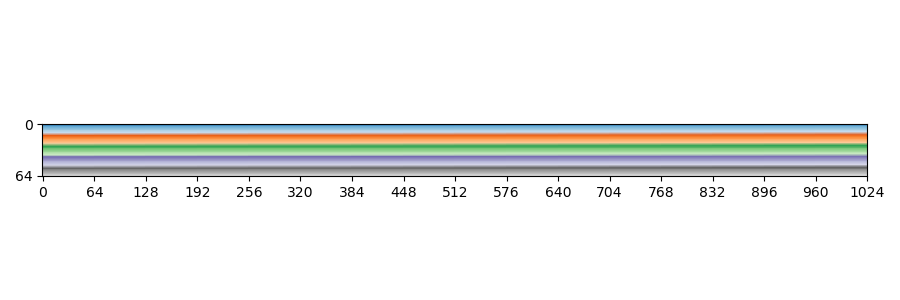

In [29]:
FIGSIZE = (9.,3.)
fig = plt.figure(figsize=FIGSIZE)
_ = plt.imshow(tim, interpolation='none', cmap=grad_cmap)
_ = plt.xticks(np.arange(0, AZIMUTH_PTS+1, ELEVATION_PTS))
_ = plt.yticks(np.arange(0, ELEVATION_PTS+1, ELEVATION_PTS))
plt.tight_layout()

Now we plot with our `tiled_cmap` to show a *harsh transition* between column firings. This image clearly shows that the data are being laid out into memory not as we would expect, given the shape of the array.

<IPython.core.display.Javascript object>


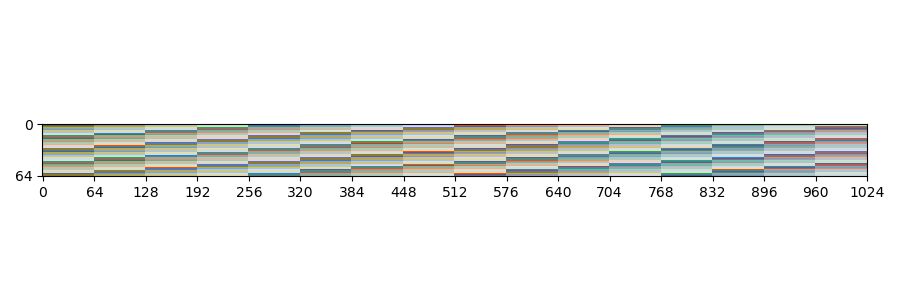

In [30]:
fig = plt.figure(figsize=FIGSIZE)
_ = plt.imshow(tim, interpolation='none', cmap=tiled_cmap)
_ = plt.xticks(np.arange(0, AZIMUTH_PTS+1, ELEVATION_PTS))
_ = plt.yticks(np.arange(0, ELEVATION_PTS+1, ELEVATION_PTS))
plt.tight_layout()

Reshaping Filter Necessary to Fix the Problem
-------------------------------------------------------------------

In order to work with these data in a meaningful and intuitive way, we need to reshape the data. To be clear, every piece of software that intends to work with the array data directly will need to do something like this. Additionally, it would be fair to say that the PCL metadata on the ROS messages are incorrect based on how the data are laid out in memory.

In [31]:
tim2 = np.reshape(tim, (AZIMUTH_PTS, -1)).T
tim2

array([[       0,    97536,   196352, ..., 99639040, 99737344, 99835904],
       [       0,    97536,   196352, ..., 99639040, 99737344, 99835904],
       [       0,    97536,   196352, ..., 99639040, 99737344, 99835904],
       ...,
       [       0,    97536,   196352, ..., 99639040, 99737344, 99835904],
       [       0,    97536,   196352, ..., 99639040, 99737344, 99835904],
       [       0,    97536,   196352, ..., 99639040, 99737344, 99835904]],
      dtype=uint32)

We can see that the numerical data now look correct. Let's visualize it with our two colormaps from above. In the first, we expect to see our nice left-to-right gradient, consisent with how the LiDAR spins. In our second, we expect to see the nice segmentation between column firings of the LiDAR encoded as vertical lines.

<IPython.core.display.Javascript object>


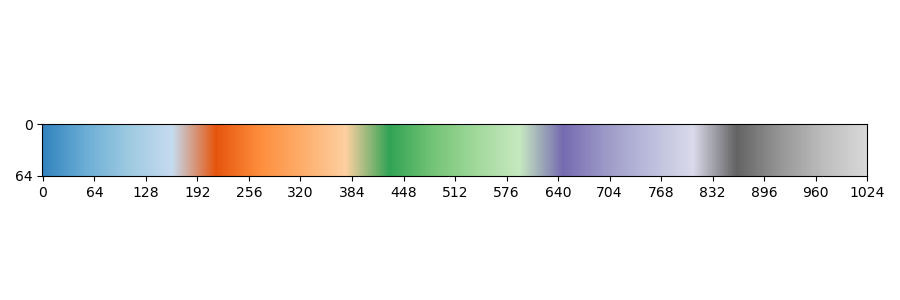

In [32]:
fig = plt.figure(figsize=FIGSIZE)
_ = plt.imshow(tim2, interpolation='none', cmap=grad_cmap)
_ = plt.xticks(np.arange(0, AZIMUTH_PTS+1, ELEVATION_PTS))
_ = plt.yticks(np.arange(0, ELEVATION_PTS+1, ELEVATION_PTS))
plt.tight_layout()

<IPython.core.display.Javascript object>


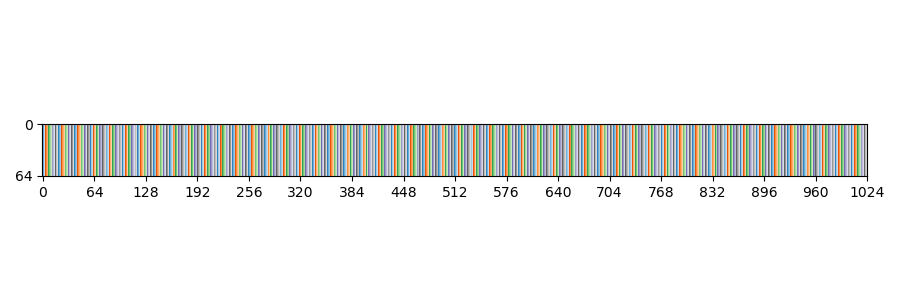

In [33]:
fig = plt.figure(figsize=FIGSIZE)
_ = plt.imshow(tim2, interpolation='none', cmap=tiled_cmap)
_ = plt.xticks(np.arange(0, AZIMUTH_PTS+1, ELEVATION_PTS))
_ = plt.yticks(np.arange(0, ELEVATION_PTS+1, ELEVATION_PTS))
plt.tight_layout()

The ROS2 Ouster driver should write its data into the memory buffer (or at least deliver it to the user) as it is shown in the two images above after the reshaping filter has been applied. We will work on a solution in the open-source driver to address this problem.